# import necessary libraries

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"]="2"
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, StandardScaler, OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score, roc_curve, auc,ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K
import optuna
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, matthews_corrcoef

# Loading the data

In [2]:
train=pd.read_csv("/kaggle/input/playground-series-s4e8/train.csv")
test=pd.read_csv("/kaggle/input/playground-series-s4e8/test.csv")
train.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-root,stem-surface,stem-color,veil-type,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,NaN,y,o,NaN,NaN,t,z,NaN,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,NaN,s,n,NaN,NaN,f,f,NaN,l,w
3,3,e,3.88,f,y,g,f,s,NaN,g,...,NaN,NaN,w,NaN,NaN,f,f,NaN,d,u
4,4,e,5.85,x,l,w,f,d,NaN,w,...,NaN,NaN,w,NaN,NaN,f,f,NaN,g,a


# Getting insight about the data

In [3]:
print(train.shape,test.shape)

(3116945, 22) (2077964, 21)


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3116945 entries, 0 to 3116944
Data columns (total 22 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   class                 object 
 2   cap-diameter          float64
 3   cap-shape             object 
 4   cap-surface           object 
 5   cap-color             object 
 6   does-bruise-or-bleed  object 
 7   gill-attachment       object 
 8   gill-spacing          object 
 9   gill-color            object 
 10  stem-height           float64
 11  stem-width            float64
 12  stem-root             object 
 13  stem-surface          object 
 14  stem-color            object 
 15  veil-type             object 
 16  veil-color            object 
 17  has-ring              object 
 18  ring-type             object 
 19  spore-print-color     object 
 20  habitat               object 
 21  season                object 
dtypes: float64(3), int64(1), object(18)
memory

In [5]:
print("training null values\n",train.isnull().sum())
print("\n\n\ntest null values\n",test.isnull().sum())
print("\n\n duplicate in train \n\n ",train.duplicated().sum())
print("\n\n duplicate in test\n\n",test.duplicated().sum())

training null values
 id                            0
class                         0
cap-diameter                  4
cap-shape                    40
cap-surface              671023
cap-color                    12
does-bruise-or-bleed          8
gill-attachment          523936
gill-spacing            1258435
gill-color                   57
stem-height                   0
stem-width                    0
stem-root               2757023
stem-surface            1980861
stem-color                   38
veil-type               2957493
veil-color              2740947
has-ring                     24
ring-type                128880
spore-print-color       2849682
habitat                      45
season                        0
dtype: int64



test null values
 id                            0
cap-diameter                  7
cap-shape                    31
cap-surface              446904
cap-color                    13
does-bruise-or-bleed         10
gill-attachment          349821
gill-spacing    

# Feature Importance :  Chi-Square test of independence
     - Two hypothesis test
        - Null-hypothesis: asserts that the feature is independent. if p-value for 
             a feature is less than the threshold then this hypothesis is rejected 
              { menas feature and target have relation}
        - Alternative-hypothesis: asserts that the feature is not independent
             { feautre and target has relationship}

In [6]:
alpha = 0.05
values = {}

for col in train.columns:
    if col == "class":
        continue
        
    A, B = train[col], train["class"]

    dfObserved = pd.crosstab(A, B) 
    chi2, p, dof, expected = scipy.stats.chi2_contingency(dfObserved.values)
    values[col] = p
    if p < alpha:
        # Reject null hypothesis
        print("{} is important. (p = {})".format(col, p))
    else:
        # Accept null hypothesis
        print("{} is NOT important. (p = {})".format(col, p))

id is NOT important. (p = 0.4997336950403224)
cap-diameter is important. (p = 0.0)
cap-shape is important. (p = 0.0)
cap-surface is important. (p = 0.0)
cap-color is important. (p = 0.0)
does-bruise-or-bleed is important. (p = 0.0)
gill-attachment is important. (p = 0.0)
gill-spacing is important. (p = 0.0)
gill-color is important. (p = 0.0)
stem-height is important. (p = 0.0)
stem-width is important. (p = 0.0)
stem-root is important. (p = 0.0)
stem-surface is important. (p = 0.0)
stem-color is important. (p = 0.0)
veil-type is NOT important. (p = 0.37683440676671315)
veil-color is important. (p = 0.0)
has-ring is important. (p = 0.0)
ring-type is important. (p = 0.0)
spore-print-color is important. (p = 0.0)
habitat is important. (p = 0.0)
season is important. (p = 0.0)


In [7]:
train= train.drop(['veil-type'], axis=1)
test= test.drop(['veil-type'], axis=1)

In [8]:
num_cols=train.select_dtypes(include=["float"]).columns
cat_cols=train.select_dtypes(include=["object"]).columns.difference(["class"])
print(f"numerical columns\n {num_cols} \n\n\n categorical columns \n {cat_cols}")

numerical columns
 Index(['cap-diameter', 'stem-height', 'stem-width'], dtype='object') 


 categorical columns 
 Index(['cap-color', 'cap-shape', 'cap-surface', 'does-bruise-or-bleed',
       'gill-attachment', 'gill-color', 'gill-spacing', 'habitat', 'has-ring',
       'ring-type', 'season', 'spore-print-color', 'stem-color', 'stem-root',
       'stem-surface', 'veil-color'],
      dtype='object')


# Handling missing values

In [9]:
def handle_missing_values(df,num_cols,cat_cols):
    for col in num_cols:
        mode=df[col].mode()[0]
        df[col].fillna(mode,inplace=True)
    for col in cat_cols:
        mode=df[col].mode()[0]
        df[col].fillna(mode,inplace=True)
    return df
        

In [10]:
train=handle_missing_values(train,num_cols,cat_cols)
train.isnull().sum()

id                      0
class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-root               0
stem-surface            0
stem-color              0
veil-color              0
has-ring                0
ring-type               0
spore-print-color       0
habitat                 0
season                  0
dtype: int64

In [11]:
test=handle_missing_values(test,num_cols,cat_cols)
test.isnull().sum()

id                      0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-root               0
stem-surface            0
stem-color              0
veil-color              0
has-ring                0
ring-type               0
spore-print-color       0
habitat                 0
season                  0
dtype: int64

In [12]:
train.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-width,stem-root,stem-surface,stem-color,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,e,8.80,f,s,u,f,a,c,w,...,15.39,b,s,w,w,f,f,k,d,a
1,1,p,4.51,x,h,o,f,a,c,n,...,6.48,b,y,o,w,t,z,k,d,w
2,2,e,6.94,f,s,b,f,x,c,w,...,9.93,b,s,n,w,f,f,k,l,w
3,3,e,3.88,f,y,g,f,s,c,g,...,6.53,b,s,w,w,f,f,k,d,u
4,4,e,5.85,x,l,w,f,d,c,w,...,8.36,b,s,w,w,f,f,k,g,a


# Encoding


In [13]:
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder

class DataEncoder:
    def __init__(self, cat_cols, target_col="class"):
        self.cat_cols = cat_cols
        self.target_col = target_col
        self.ordinal_encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        self.label_encoder = LabelEncoder()
        
    def fit_transform(self, train):
        train[self.cat_cols] = self.ordinal_encoder.fit_transform(train[self.cat_cols])
        train[self.target_col] = self.label_encoder.fit_transform(train[self.target_col])
        return train

    def transform(self, test):
        test[self.cat_cols] = self.ordinal_encoder.transform(test[self.cat_cols])
        return test

    def transform_new_data(self, df):
        df[self.cat_cols] = self.ordinal_encoder.transform(df[self.cat_cols])
        return df

# Standalone function for encoding
def encoding(train, test, cat_cols, target_col="class"):
    encoder = DataEncoder(cat_cols, target_col)
    train_encoded = encoder.fit_transform(train)
    test_encoded = encoder.transform(test)
    return train_encoded, test_encoded, encoder


In [14]:
# Standalone function for encoding
def encoding(train, test, cat_cols, target_col="class"):
    encoder = DataEncoder(cat_cols, target_col)
    train_encoded = encoder.fit_transform(train)
    test_encoded = encoder.transform(test)
    return train_encoded, test_encoded, encoder

In [15]:
train, test, encoder = encoding(train, test, cat_cols,target_col="class")

In [16]:
train.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-width,stem-root,stem-surface,stem-color,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,0,8.80,53.0,72.0,72.0,8.0,44.0,28.0,59.0,...,15.39,15.0,51.0,55.0,21.0,5.0,18.0,17.0,25.0,0.0
1,1,1,4.51,71.0,56.0,64.0,8.0,44.0,28.0,46.0,...,6.48,15.0,58.0,47.0,21.0,18.0,39.0,17.0,25.0,3.0
2,2,0,6.94,53.0,72.0,49.0,8.0,75.0,28.0,59.0,...,9.93,15.0,51.0,46.0,21.0,5.0,18.0,17.0,36.0,3.0
3,3,0,3.88,53.0,81.0,57.0,8.0,70.0,28.0,37.0,...,6.53,15.0,51.0,55.0,21.0,5.0,18.0,17.0,25.0,2.0
4,4,0,5.85,71.0,65.0,74.0,8.0,47.0,28.0,59.0,...,8.36,15.0,51.0,55.0,21.0,5.0,18.0,17.0,29.0,0.0


# Feature Engineering

In [17]:
# Cap color and surface interaction (now numeric after encoding)
# def feature_engineering(df):
#     epsilon=1e-8
#     df['cap_color_surface_interaction'] = df['cap-color'] + df['cap-surface']
#     df['gill_color_spacing_interaction'] = df['gill-color'] + df['gill-spacing']
#     df['cap_stem_diameter_ratio'] = df['cap-diameter'] / (df['stem-width'] + epsilon)
#     df['stem_root_surface_interaction'] = df['stem-root'] + df['stem-surface']
#     df['season_habitat_interaction'] = df['season'] + df['habitat']
#     df['cap_shape_gill_attachment_interaction'] = df['cap-shape'] + df['gill-attachment']
#     df['cap_stem_height_ratio'] = df['cap-diameter'] / (df['stem-height'] + epsilon)
#     return df



In [18]:
# # applying feature engineering
# train = feature_engineering(train)
# test = feature_engineering(test)

In [19]:
print(train.shape,test.shape)

(3116945, 21) (2077964, 20)


In [20]:
train.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-width,stem-root,stem-surface,stem-color,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,0,8.80,53.0,72.0,72.0,8.0,44.0,28.0,59.0,...,15.39,15.0,51.0,55.0,21.0,5.0,18.0,17.0,25.0,0.0
1,1,1,4.51,71.0,56.0,64.0,8.0,44.0,28.0,46.0,...,6.48,15.0,58.0,47.0,21.0,18.0,39.0,17.0,25.0,3.0
2,2,0,6.94,53.0,72.0,49.0,8.0,75.0,28.0,59.0,...,9.93,15.0,51.0,46.0,21.0,5.0,18.0,17.0,36.0,3.0
3,3,0,3.88,53.0,81.0,57.0,8.0,70.0,28.0,37.0,...,6.53,15.0,51.0,55.0,21.0,5.0,18.0,17.0,25.0,2.0
4,4,0,5.85,71.0,65.0,74.0,8.0,47.0,28.0,59.0,...,8.36,15.0,51.0,55.0,21.0,5.0,18.0,17.0,29.0,0.0


In [21]:
np.isinf(train).sum()

id                      0
class                   0
cap-diameter            0
cap-shape               0
cap-surface             0
cap-color               0
does-bruise-or-bleed    0
gill-attachment         0
gill-spacing            0
gill-color              0
stem-height             0
stem-width              0
stem-root               0
stem-surface            0
stem-color              0
veil-color              0
has-ring                0
ring-type               0
spore-print-color       0
habitat                 0
season                  0
dtype: int64

# Scaling

In [22]:
class StandardScalerWrapper:
    def __init__(self):
        self.scaler = StandardScaler()

    def fit_transform(self, train):
        self.cols_to_scale = train.select_dtypes(include=["float", "int"]).columns.difference(["class","id"])
        train[self.cols_to_scale] = self.scaler.fit_transform(train[self.cols_to_scale])
        return train

    def transform(self, test):
        test[self.cols_to_scale] = self.scaler.transform(test[self.cols_to_scale])
        return test
    
    def transform_new(self, df):
        df[self.cols_to_scale] = self.scaler.transform(df[self.cols_to_scale])
        return df



In [23]:
scaler_wrapper = StandardScalerWrapper()
train = scaler_wrapper.fit_transform(train)
test = scaler_wrapper.transform(test)

In [24]:
train.head()

,id,class,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,...,stem-width,stem-root,stem-surface,stem-color,veil-color,has-ring,ring-type,spore-print-color,habitat,season
0,0,0,0.534606,-1.111069,0.329188,1.039733,-0.461411,-0.834809,-0.422058,0.895723,...,0.523282,-0.239241,0.111345,0.785557,0.120151,-0.561942,-0.294854,-0.202999,-0.535818,-0.954002
1,1,1,-0.386404,0.879158,-1.155119,-0.162778,-0.461411,-0.834809,-0.422058,-0.562029,...,-0.577333,-0.239241,1.931741,-0.540141,0.120151,1.779556,4.511319,-0.202999,-0.535818,1.762755
2,2,0,0.135287,-1.111069,0.329188,-2.417487,-0.461411,1.829251,-0.422058,0.895723,...,-0.151169,-0.239241,0.111345,-0.705853,0.120151,-0.561942,-0.294854,-0.202999,2.118464,1.762755
3,3,0,-0.521657,-1.111069,1.164112,-1.214976,-0.461411,1.399564,-0.422058,-1.571242,...,-0.571157,-0.239241,0.111345,0.785557,0.120151,-0.561942,-0.294854,-0.202999,-0.535818,0.857169
4,4,0,-0.098722,0.879158,-0.320196,1.340360,-0.461411,-0.576997,-0.422058,0.895723,...,-0.345105,-0.239241,0.111345,0.785557,0.120151,-0.561942,-0.294854,-0.202999,0.429376,-0.954002


# Splitting data

In [25]:
X=train.drop(columns=["class","id"])
y=train["class"]

print(len(X),len(y))

3116945 3116945


In [26]:
X_train,X_val,y_train,y_val=train_test_split(X,y,test_size=.2,random_state=42)
print(X_train.shape,X_val.shape)

(2493556, 19) (623389, 19)


In [27]:
X_train.head()

,cap-diameter,cap-shape,cap-surface,cap-color,does-bruise-or-bleed,gill-attachment,gill-spacing,gill-color,stem-height,stem-width,stem-root,stem-surface,stem-color,veil-color,has-ring,ring-type,spore-print-color,habitat,season
1252551,-0.800751,0.436885,0.978573,-0.313092,2.167183,-0.576997,-0.422058,-0.562029,-1.288389,-0.674918,-0.239241,0.111345,-0.705853,0.120151,-0.561942,-0.294854,-0.202999,-0.535818,-0.954002
1799166,-0.961767,-1.663910,-1.247888,-0.162778,-0.461411,-0.834809,-0.422058,-0.562029,-0.366083,-1.044260,-0.239241,0.111345,-0.705853,0.120151,-0.561942,-0.294854,-0.202999,2.359763,-0.954002
1936146,-0.233976,0.879158,-0.876811,-0.162778,-0.461411,-0.147310,-0.422058,1.119992,0.359909,-0.462454,-0.239241,0.111345,-1.202990,0.120151,-0.561942,-0.294854,-0.202999,2.359763,-0.954002
1464811,-0.384257,-1.111069,0.700265,1.640988,-0.461411,1.399564,1.611687,1.119992,-0.184585,0.195938,-0.239241,-1.969106,1.116982,0.120151,-0.561942,-0.294854,-0.202999,-0.535818,-0.954002
767639,-0.027876,-1.111069,0.700265,-0.313092,-0.461411,-0.576997,-0.422058,1.119992,-0.006791,-0.106700,-0.239241,0.111345,-0.705853,0.120151,-0.561942,-0.294854,-0.202999,2.118464,1.762755


# class imbalance and class weights

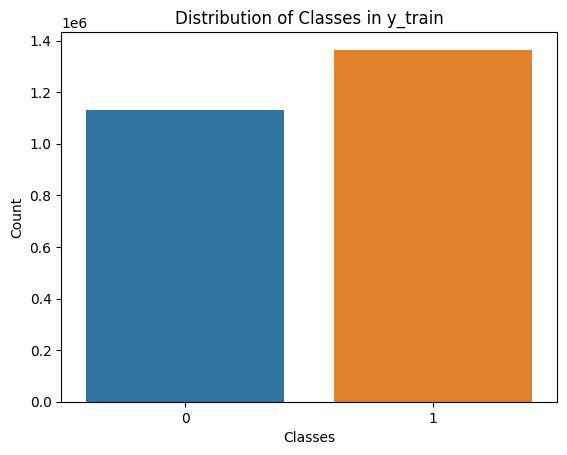

In [28]:
sns.countplot(x=y_train)
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Distribution of Classes in y_train')
plt.show()

In [29]:
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_arr=np.array(class_weights)
class_weights_dict = dict(enumerate(class_weights))

class_weights_dict

{0: 1.1041719803888228, 1: 0.913789464117666}

# Model

In [30]:
# XGBClassifier
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

## XGB

In [31]:
xgb_params={'n_estimators': 432,
            'max_depth': 18, 
            'learning_rate': 0.019177494166556952, 
            'subsample': 0.6944494028059239, 
            'colsample_bytree': 0.5177980824894136, 
            'gamma': 0.0004342336537981622, 
            'lambda': 1.3527652792856453e-06, 
            'alpha': 4.10797226500692e-08, 
#             'scale_pos_weight': 1.0121323580230017
            'scale_pos_weight':class_weights_dict[1]/class_weights_dict[0]
            
           }

In [32]:
# model_xgb = XGBClassifier(booster='gbtree', learning_rate=0.1, max_depth=12, n_estimators=100,class_weight=class_weights_dict, n_jobs=-1)
model_xgb = XGBClassifier(**xgb_params)

model_xgb.fit(X_train, y_train)

xgb_pred = model_xgb.predict_proba(X_val)[:, 1] 
xgb_label = np.where(xgb_pred > 0.5, 1, 0) 

print(confusion_matrix(y_val, xgb_label)) 
print(classification_report(y_val, xgb_label))
print('xgb accuracy for val: {0:.6f}'.format(accuracy_score(y_val, xgb_label)))  #0.991182

[[280266   2131]
 [  3019 337973]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    282397
           1       0.99      0.99      0.99    340992

    accuracy                           0.99    623389
   macro avg       0.99      0.99      0.99    623389
weighted avg       0.99      0.99      0.99    623389

xgb accuracy for val: 0.991739


## LGBM

In [33]:
lgbm_params={'num_leaves': 989,
             'metric':'auc',
             'learning_rate': 0.01150197154409214, 
             'feature_fraction': 0.6153388926958593, 
             'bagging_fraction' :0.830726975975083, 
             'bagging_freq': 7, 
             'lambda_l1': 9.285703159386265e-05,
             'lambda_l2': 3.5283439660576336e-08,
             'max_depth': 19,
             'max_bin': 60481,
             'n_estimators': 2026,
             'verbose': -1,
             'scale_pos_weight':class_weights_dict[1]/class_weights_dict[0]

            }

In [34]:
# model_lgbm = LGBMClassifier(random_state=1, verbose=-1, num_leaves=127, learning_rate=0.1, class_weight=class_weights_dict,n_estimators=800)
model_lgbm=LGBMClassifier(**lgbm_params)
model_lgbm.fit(X_train, y_train)

lgbm_pred = model_lgbm.predict_proba(X_val)[:, 1] 
lgbm_label = np.where(lgbm_pred > 0.5, 1, 0) 

print(confusion_matrix(y_val, lgbm_label)) 
print(classification_report(y_val, lgbm_label))
print('lgbm accuracy for val: {0:.6f}'.format(accuracy_score(y_val, lgbm_label)))



[[280229   2168]
 [  3001 337991]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    282397
           1       0.99      0.99      0.99    340992

    accuracy                           0.99    623389
   macro avg       0.99      0.99      0.99    623389
weighted avg       0.99      0.99      0.99    623389

lgbm accuracy for val: 0.991708


## Cat

In [35]:
catb_params = {
    "n_estimators": 10000,
    "learning_rate": 0.02,
    'task_type': 'GPU', 
    'random_strength': 1,
    'max_bin': 255, 
    'depth': 10,
    'l2_leaf_reg': 5,
    'grow_policy': 'SymmetricTree',
    'boosting_type': 'Plain',
    'bootstrap_type': 'Bernoulli',
    'subsample': 0.8,
    'od_type': 'Iter',
    'od_wait': 100 ,
    'verbose': False  
}


In [36]:
# CatBoostClassifier
from catboost import CatBoostClassifier

# model_cat = CatBoostClassifier(random_state=1, verbose=0, depth=10, iterations=1000, class_weights=class_weights_dict,learning_rate=0.1)
model_cat=CatBoostClassifier(**catb_params)
model_cat.fit(X_train, y_train)

cat_pred = model_cat.predict_proba(X_val)[:, 1] 
cat_label = np.where(cat_pred > 0.5, 1, 0) 

print(confusion_matrix(y_val, cat_label)) 
print(classification_report(y_val, cat_label))
print('cat accuracy for val: {0:.6f}'.format(accuracy_score(y_val, cat_label)))



[[280075   2322]
 [  3000 337992]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99    282397
           1       0.99      0.99      0.99    340992

    accuracy                           0.99    623389
   macro avg       0.99      0.99      0.99    623389
weighted avg       0.99      0.99      0.99    623389

cat accuracy for val: 0.991463


# Voting classifier

In [37]:
from sklearn.ensemble import VotingClassifier

voting_model = VotingClassifier(estimators=[
    ('xgb', model_xgb),
    ('lgb', model_lgbm),
    ('cat', model_cat)
], voting='soft')

voting_model.fit(X_train, y_train)


VotingClassifier(estimators=[('xgb',
                              XGBClassifier(alpha=4.10797226500692e-08,
                                            base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5177980824894136,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.0004342336537981622,
                                            grow_policy=None,
                                            imp...
                                             bagging_freq=7,
                                             feature_fraction=0.6153388926958593,
                                             lambda_l1=9.285703159386265e-05,
                                             lambda_l2=3.5283439660576336e-08,
                                             learning_rate=0.01150197154409214,
                                             max_bin=60481, max_depth=19,
                                             metric='auc', n_estimators=2026,
                                             num_leaves=989,
                                             scale_pos_weight=0.8275789282353321,
                                             verbose=-1)),
                             ('cat',
                              <catboost.core.CatBoostClassifier object at 0x7a6b6202dc90>)],
                 voting='soft')

In [38]:
from sklearn.ensemble import VotingClassifier

voting_model2 = VotingClassifier(estimators=[
    ('xgb', model_xgb),
    ('lgb', model_lgbm),
], voting='soft')

voting_model2.fit(X_train, y_train)

VotingClassifier(estimators=[('xgb',
                              XGBClassifier(alpha=4.10797226500692e-08,
                                            base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=0.5177980824894136,
                                            device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None,
                                            gamma=0.0004342336537981622,
                                            grow_policy=None,
                                            imp...
                                            n_estimators=432, n_jobs=None, ...)),
                             ('lgb',
                              LGBMClassifier(bagging_fraction=0.830726975975083,
                                             bagging_freq=7,
                                             feature_fraction=0.6153388926958593,
                                             lambda_l1=9.285703159386265e-05,
                                             lambda_l2=3.5283439660576336e-08,
                                             learning_rate=0.01150197154409214,
                                             max_bin=60481, max_depth=19,
                                             metric='auc', n_estimators=2026,
                                             num_leaves=989,
                                             scale_pos_weight=0.8275789282353321,
                                             verbose=-1))],
                 voting='soft')

# Stacking Classifier

In [39]:
# from sklearn.ensemble import StackingClassifier

# meta_model = XGBClassifier(n_estimators=100, learning_rate=0.05, max_depth=3, n_jobs=-1)

# stacking_model = StackingClassifier(
#     estimators=[
#         ('xgb', model_xgb),
#         ('lgb', model_lgbm),
#         ('cat', model_cat)
#     ],
#     final_estimator=meta_model,
#     cv=5,
#     n_jobs=-1
# )

# stacking_model.fit(X_train, y_train)


# Evaluation on test set and saving submission file

In [40]:
X_test=test.drop(columns="id",axis=1)
X_test.shape

(2077964, 19)

In [41]:
def predict(model,test_data):
    predictions=model.predict_proba(test_data)
    predicted_labels=np.where(predictions>.5,1,0)
    predicted_labels=np.argmax(predicted_labels,axis=1)
    class_mapping={0:'e',1:'p'}
    predicted_class=[class_mapping[label] for label in predicted_labels]
    return predicted_class
    
    

In [42]:
# with xgb and lgb
voting_pred2=predict(voting_model2,X_test)
submission_voting2=pd.DataFrame({"id":test["id"].values,"class":voting_pred2})
submission_voting2.to_csv("submission.csv",index=False)

In [43]:
# voting_pred=predict(voting_model,X_test)
# submission_voting=pd.DataFrame({"id":test["id"].values,"class":voting_pred})
# submission_voting.to_csv("submission.csv",index=False)


In [44]:
# stack_pred=predict(stacking_model,X_test)
# submission_stack=pd.DataFrame({"id":test["id"].values,"class":stack_pred})
# submission_stack.to_csv("submission_stack.csv",index=False)

In [45]:
print("Notebook completed")

Notebook completed
